# 1 - Downloading The Pile - Deduplicated and MiniPile

**Objectives:**
- [x] Download "The Pile - Deduplicated" to a specified directory
- [x] Download "MiniPile" to a specified directory

We want to download the datasets [EleutherAI/the_pile_deduplicated](https://huggingface.co/datasets/EleutherAI/the_pile_deduplicated) and [JeanKaddour/minipile](https://huggingface.co/datasets/JeanKaddour/minipile) through HuggingFace to a specific directory.<br>
HuggingFace can be a bit stubborn in that it loads the datasets and their caches to some default directory.<br>
We can't do that here, so we need to implement a custom download function based on the HuggingFace API.<br>
Thankfully, the HuggingFace-Hub's `snapshot_download` function performs much of the heavy lifting for us in that regard.

In [1]:
import os
from pathlib import Path
from huggingface_hub import snapshot_download

In [2]:
down_dir = "/vol/tmp/koppelmm"

In [3]:
def download_dataset(down_dir: str, target_folder: str, cache_folder: str, repo_id: str) -> None:
    # Download a dataset without affecting local cache. 
    # Download genuinely only to target_folder.
    down_dir = Path(down_dir)
    target_dir = down_dir / target_folder
    cache_dir = down_dir / cache_folder

    os.makedirs(target_dir, exist_ok=True)
    os.makedirs(cache_dir, exist_ok=True)

    print(f"Downloading {repo_id}...")

    # I tried fiddling with os.environs, I wanted to use the load_dataset function
    # but that's really not needed, snapshot_download suffices
    while True:
        try:
            snapshot_download(repo_id, repo_type="dataset", cache_dir=str(cache_dir), local_dir=str(target_dir))
            break
        except Exception as _:
            continue

With the download logic in place, we can go right ahead and download the datasets to their intended directories.

In [ ]:
download_dataset(down_dir=down_dir, target_folder="Pile_Deduplicated", 
                 cache_folder="Pile_Deduplicated_Cache", repo_id="EleutherAI/the_pile_deduplicated")

[The Pile Deduplicated](https://huggingface.co/datasets/EleutherAI/the_pile_deduplicated) is stated to measure $451$ GB at $134,318,121$ rows.<br>
The dataset only consists of a train split. Each row only consists of the value to the single attribute `text`.

In [ ]:
download_dataset(down_dir=down_dir, target_folder="MiniPile", 
                 cache_folder="MiniPile_Cache", repo_id="JeanKaddour/minipile")

[MiniPile](https://huggingface.co/datasets/JeanKaddour/minipile) is stated to measure $3.18$ GB at $1,000,000:500:10,000$ train:val:test rows.<br>
Again, each row only consists of the value to the single attribute `text`.

MiniPile's training set is therefore $0.745\%$ the size of The Pile Deduplicated, while retaining a memory footprint of $0.705\%$.

---

## (Some) Exploratory Data Analysis

For comparison, and mostly for fun.<br>
I stumbled across [PyGWalker](https://github.com/Kanaries/pygwalker) and decided to give it a shot for looking a bit further into training data from MiniPile.

In [ ]:
!pip install matplotlib seaborn wordcloud

In [13]:
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

%matplotlib inline

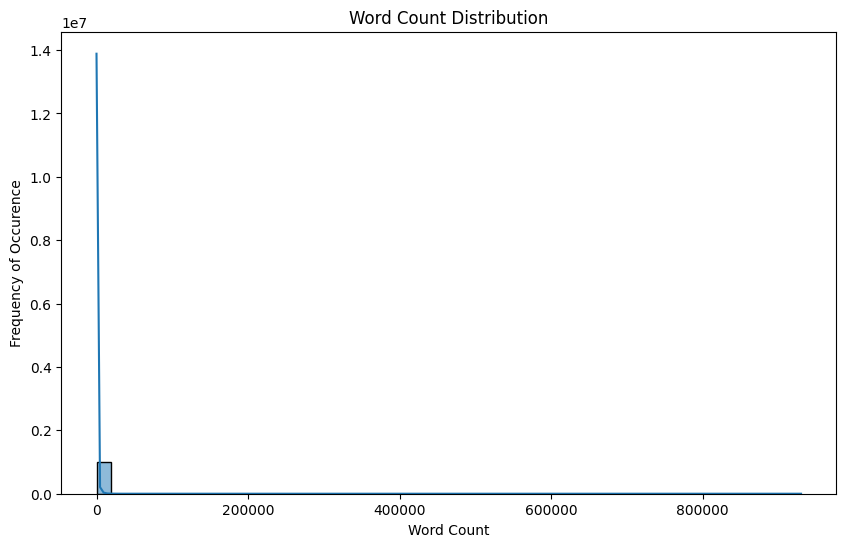

[('the', 46273675), ('of', 23645711), ('and', 20278174), ('to', 19549375), ('a', 16105849), ('in', 15588963), ('is', 9679999), ('that', 8111288), ('for', 8014297), ('with', 5896119), ('on', 5010363), ('as', 4912927), ('was', 4342515), ('be', 4315514), ('this', 4178044), ('it', 4153150), ('by', 4075041), ('i', 3997621), ('=', 3966025), ('are', 3891138), ('at', 3458970), ('from', 3430069), ('or', 3279427), ('not', 3182725), ('you', 3124774), ('we', 2998420), ('have', 2956292), ('an', 2917529), ('if', 2299889), ('but', 2214059), ('-', 2096678), ('were', 2080686), ('he', 2074007), ('which', 2016593), ('can', 1954685), ('has', 1874547), ('+', 1780226), ('{', 1774643), ('will', 1714208), ('all', 1713836), ('they', 1691760), ('his', 1675734), ('one', 1566157), ('}', 1539036), ('their', 1452464), ('when', 1451952), ('more', 1411543), ('what', 1392283), ('your', 1308072), ('had', 1274550)]


In [17]:
down_path = Path(down_dir)

# Loading minipile train + val splits from the local directory 
# https://stackoverflow.com/questions/77020278/how-to-load-a-huggingface-dataset-from-local-path
# https://github.com/MK2112/mobileYOLOv3/blob/main/mobileyolov3-cocotext.ipynb
# Split is named exactly like with the original dataset https://huggingface.co/datasets/JeanKaddour/minipile
minipile_train = load_dataset("parquet",
                              data_files={
                                  "train": str(down_path / "MiniPile" / "data" / "train-*.parquet"),
                                  "validation": str(down_path / "MiniPile" / "data" / "validation-*.parquet"),
                                  "test": str(down_path / "MiniPile" / "data" / "test-*.parquet")
                              },
                              cache_dir=str(down_path / "MiniPile_Cache"),
                              split="train")

df = pd.DataFrame(minipile_train)[['text']]

# Word Counts
df['word_count'] = df['text'].str.split().str.len()
plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency of Occurence')
plt.show()

print(Counter(' '.join(df['text']).lower().split()).most_common(50))

I find that conducting EDA like this, while informative, takes hilarious amounts of time.<br>
I will elect not to apply this further, but instead utilize HuggingFace's SQL-based Interaction options for aggregations and informations about the dataset. For example, after seeing the above graphs, I wanted to know the largest and the smallest example in the dataset, as the distribution is shown to be pretty extreme.

On HuggingFace, I ran this to get the answers within about a minute:<br>
`SELECT MIN(LENGTH(text)), MAX(LENGTH(text)) FROM train;`

`JeanKaddour/MiniPile` contains a smallest example of char size $8$, and a largest one with size $5,766,478$.